# Projet_09 : Réalisez un traitement dans un environnement Big Data sur le Cloud

# Etape 1 : Préparez la chaîne de traitement PySpark en local
---

## Import des librairies

In [98]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt

import time
from contextlib import contextmanager

In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

Num GPUs Available: 1


In [99]:
@contextmanager
def timer(name):
    """Decorator that print the elapsed time and argument."""
    timing = {}
    t0 = time.time()
    yield timing
    timing["elapsed"] = time.time() - t0
    print(f"{name} - done in {timing['elapsed']:.0f}s")

In [103]:
from numba import cuda 

def clear_GPU_memory():
    device = cuda.get_current_device()
    device.reset()

---
## Définition des emplacements :

In [3]:
PATH = '/data/Formation_OC/Projet_09'
PATH_Data = PATH+'/data/fruits/fruits-360_dataset/fruits-360/Test/'
PATH_Result = PATH+'/data/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /data/Formation_OC/Projet_09
PATH_Data:   /data/Formation_OC/Projet_09/data/fruits/fruits-360_dataset/fruits-360/Test/
PATH_Result: /data/Formation_OC/Projet_09/data/Results


---
---
## 1.1 - Création de la SparkSession

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**. <br />
<u>Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur <br />
dans l’ensemble du cluster</u>. <u>Une SparkSession correspond toujours à une application Spark</u>.

<u>Ici nous créons une session spark en spécifiant dans l'ordre</u> :
 1. un **nom pour l'application**, qui sera affichée dans l'interface utilisateur Web Spark "**P9**"
 2. que l'application doit s'exécuter **localement**. <br />
   Nous ne définissons pas le nombre de cœurs à utiliser (comme .master('local[4]) pour 4 cœurs à utiliser), <br />
   nous utiliserons donc tous les cœurs disponibles dans notre processeur.<br />
 3. une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** <br />
   que nous utiliserons pour enregistrer et charger le résultat de notre travail.
 4. vouloir **obtenir une session spark** existante ou si aucune n'existe, en créer une nouvelle

**Force Spark à utiliser l'env "projet_09" afin de trouver tensorflow !!**

In [4]:
import os
os.environ["PYSPARK_PYTHON"] = "/home/garth/anaconda3/envs/projet_09/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/garth/anaconda3/envs/projet_09/bin/python"

In [5]:
spark = (SparkSession
             .builder
             .appName('P9')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

25/01/29 16:35:14 WARN Utils: Your hostname, ubuntu-anaconda resolves to a loopback address: 127.0.1.1; using 192.168.2.189 instead (on interface enp6s18)
25/01/29 16:35:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/29 16:35:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [6]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [7]:
spark

---
---
## 1.2 - Chargement des données

Les images sont chargées au format binaire, ce qui offre, <br />
plus de souplesse dans la façon de prétraiter les images.

Avant de charger les images, nous spécifions que nous voulons charger <br />
uniquement les fichiers dont l'extension est **jpg**.

Nous indiquons également de charger tous les objets possibles contenus <br />
dans les sous-dossiers du dossier communiqué.

In [8]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

<u>Affichage des 5 premières images contenant</u> :
 - le path de l'image
 - la date et heure de sa dernière modification
 - sa longueur
 - son contenu encodé en valeur hexadécimal

<u>Je ne conserve que le **path** de l'image et j'ajoute une colonne contenant les **labels** de chaque image</u> :

In [9]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------------------------------------------------------------+----------+
|path                                                                                                     |label     |
+---------------------------------------------------------------------------------------------------------+----------+
|file:/data/Formation_OC/Projet_09/data/fruits/fruits-360_dataset/fruits-360/Test/Watermelon/r_106_100.jpg|Watermelon|
|file:/data/Formation_OC/Projet_09/data/fruits/fruits-360_dataset/fruits-360/Test/Watermelon/r_109_100.jpg|Watermelon|
|file:/data/Formation_OC/Projet_09/data/fruits/fruits-360_dataset/fruits-360/Test/Watermelon/r_108_100.jpg|Watermelon|
|file:/data/Formation_OC/Projet_09/data/fruits/fruits-360_dataset/fruits-360

---
---
## 1.3 - Préparation du modèle :

### 1.3.1 - Chargement du modèle : **MobileNetV2**

In [10]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0


I0000 00:00:1738168530.012451    8797 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22336 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:06:10.0, compute capability: 8.6
2025-01-29 16:35:30.022826: I tensorflow/core/common_runtime/placer.cc:162] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-01-29 16:35:30.022840: I tensorflow/core/common_runtime/placer.cc:162] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.022843: I tensorflow/core/common_runtime/placer.cc:162] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.203642: I tensorflow/core/common_runtime/placer.cc:162] x: (_DeviceArg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.203666: I tensorflow/core/common_runtime/placer.cc:162] Cast: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.203669: I tensorflow/core/common_runtim

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device

2025-01-29 16:35:30.506187: I tensorflow/core/common_runtime/placer.cc:162] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.506218: I tensorflow/core/common_runtime/placer.cc:162] Cast: (Cast): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.506222: I tensorflow/core/common_runtime/placer.cc:162] y_RetVal: (_DeviceRetval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.507445: I tensorflow/core/common_runtime/placer.cc:162] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.507461: I tensorflow/core/common_runtime/placer.cc:162] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.507464: I tensorflow/core/common_runtime/placer.cc:162] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.509460: I tensorflow/core/common_runtime/placer.cc:162] seed: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2025-01-29 16:35:3

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

2025-01-29 16:35:30.709059: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.709078: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.711261: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.711279: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.713265: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.713280: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.715335: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replic

2025-01-29 16:35:30.910961: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.910976: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.912728: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.912744: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.919780: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.919805: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:30.922587: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/r

2025-01-29 16:35:31.115484: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.115502: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.118155: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.118171: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.120079: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.120095: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.121999: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /j

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:loca

2025-01-29 16:35:31.322168: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.322189: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.322967: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.322982: I tensorflow/core/common_runtime/placer.cc:162] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.322986: I tensorflow/core/common_runtime/placer.cc:162] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.325424: I tensorflow/core/common_runtime/placer.cc:162] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.325439: I tensorflow/core/common_runtime/placer.cc:162] VarHandleOp: (VarHandleOp): /job:localhost/

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

2025-01-29 16:35:31.543408: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.543430: I tensorflow/core/common_runtime/placer.cc:162] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.543435: I tensorflow/core/common_runtime/placer.cc:162] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.548925: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.548944: I tensorflow/core/common_runtime/placer.cc:162] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.548948: I tensorflow/core/common_runtime/placer.cc:162] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:31.550595: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device

---
### 1.3.2 - Création de notre modèle sans la dernière couche :

In [11]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Affichage du résumé de notre nouveau modèle où nous constatons <br />
que <u>nous récupérons bien en sortie un vecteur de dimension (1, 1, 1280)</u> :

In [12]:
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. <br />
Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser <br />
ensuite les poids aux différents workeurs.

In [13]:
brodcast_weights = sc.broadcast(new_model.get_weights())

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

2025-01-29 16:35:47.990535: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:47.990570: I tensorflow/core/common_runtime/placer.cc:162] ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:47.990573: I tensorflow/core/common_runtime/placer.cc:162] value_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:47.994366: I tensorflow/core/common_runtime/placer.cc:162] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:47.994381: I tensorflow/core/common_runtime/placer.cc:162] Identity: (Identity): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:47.994385: I tensorflow/core/common_runtime/placer.cc:162] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2025-01-29 16:35:47.997769: I tensorflow/core/common_runtime/placer.cc:162] resource: (_Arg): /job:localhost/replica:0/task:0/device:G

<u>Mettons cela sous forme de fonction</u> :

In [14]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

---
---
## 1.4 - Featurisation :

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

### 1.4.1 - Fonctions :

In [15]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/garth/anaconda3/envs/projet_09/lib/python3.9/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


---
### 1.4.2 - Exécution des actions d'extraction de features

Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), <br />
peuvent rencontrer des erreurs de type Out Of Memory (OOM).<br />

**Commande pour palier au problème de OOM :**

In [16]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [17]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<u>Rappel du PATH où seront inscrits les fichiers au format "**parquet**" <br />
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes</u> :
 1. Path des images
 2. Label de l'image
 3. Vecteur de caractéristiques de l'image

In [21]:
print(PATH_Result)

/data/Formation_OC/Projet_09/data/Results


**Vider la mémoire du GPU :**

In [104]:
clear_GPU_memory()

<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [24]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2025-01-29 16:46:04.343913: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 16:46:04.352026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738169164.361058   10404 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738169164.363767   10404 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 16:46:04.373254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

---
### 1.4.3 - Vérification des résultats :

<u>On charge les données fraichement enregistrées dans un **DataFrame Pandas**</u> :

In [25]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>On affiche les 5 premières lignes du DataFrame</u> :

In [26]:
df.head()

,path,label,features
0,file:/data/Formation_OC/Projet_09/data/fruits/...,Watermelon,"[0.0, 0.9375762, 0.14944498, 0.0, 1.27732, 0.0..."
1,file:/data/Formation_OC/Projet_09/data/fruits/...,Watermelon,"[0.0, 0.40750685, 0.022117322, 0.0, 1.5700709,..."
2,file:/data/Formation_OC/Projet_09/data/fruits/...,Pineapple Mini,"[0.0, 4.7792277, 0.0, 0.0, 0.0, 0.0, 0.0922017..."
3,file:/data/Formation_OC/Projet_09/data/fruits/...,Pineapple Mini,"[0.0, 4.9306545, 0.0, 0.0, 0.0, 0.0, 0.1350258..."
4,file:/data/Formation_OC/Projet_09/data/fruits/...,Pineapple Mini,"[0.0, 4.65893, 0.0, 0.0, 0.0, 0.0, 0.3763668, ..."


In [27]:
df.shape

(22688, 3)

<u>On valide que la dimension du vecteur de caractéristiques des images est bien de dimension 1280</u> :

In [28]:
df.loc[0,'features'].shape

(1280,)

---
---
## 1.5 - Réduction de dimension avec PCA :

Exemple PCA sur repo spark : [https://github.com/apache/spark/blob/master/examples/src/main/python/ml/pca_example.py](https://github.com/apache/spark/blob/master/examples/src/main/python/ml/pca_example.py)

In [63]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import col, udf
from pyspark.ml.linalg import Vectors, VectorUDT

---
### 1.5.1 - Création d'un dataframe Spark :

In [64]:
df_spark = spark.read.parquet(PATH_Result)

In [65]:
df_spark.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



---
### 1.5.2 - Transformation de "Floats" en vecteurs :

Afin de pouvoir réaliser une PCA sur la colonne "features" avec Spark, il faut la transformer en vecteur :

In [66]:
# array to dense vector
to_vector_udf = udf(lambda x: Vectors.dense(x), VectorUDT())

In [67]:
vector_df = df_spark.withColumn("features_vec", to_vector_udf(col("features")))

In [68]:
vector_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)



---
### 1.5.3 - PCA - Recherche du nombre de Composantes Principales :

Recherche du nombre de composantes principales pour une variance expliquée de :
* 80%
* 90%

In [75]:
pca = PCA(k=200, inputCol="features_vec", outputCol="pca_features")
pca_model = pca.fit(vector_df)

In [93]:
# explained variance
explained_variance = pca_model.explainedVariance.toArray()

# cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# find k for 80% of variance
k_optimal_80 = np.argmax(cumulative_variance >= 0.80) +1
# find k for 90% of variance
k_optimal_90 = np.argmax(cumulative_variance >= 0.90) +1

print(f"Quantity of principal components for 80% of variance : {k_optimal_80}")
print(f"Quantity of principal components for 90% of variance : {k_optimal_90}")

Quantity of principal components for 80% of variance : 80
Quantity of principal components for 90% of variance : 186


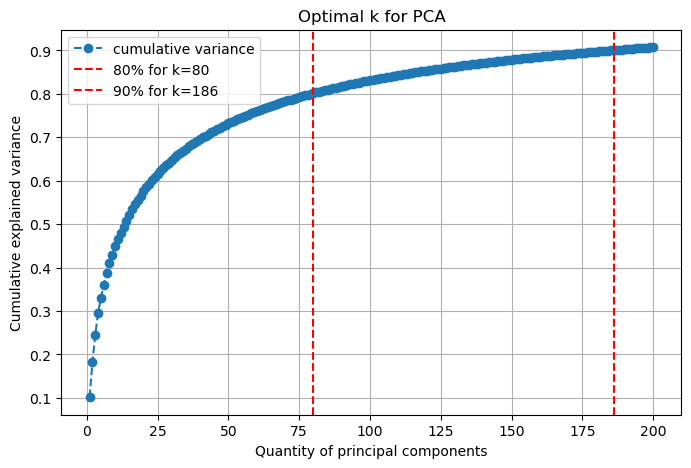

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), 
         cumulative_variance, 
         marker='o', 
         linestyle='--', 
         label="cumulative variance"
        )
plt.axvline(x=k_optimal_80, color='r', 
            linestyle='--', 
            label=f"80% for k={k_optimal_80}"
           )
plt.axvline(x=k_optimal_90, color='r', 
            linestyle='--', 
            label=f"90% for k={k_optimal_90}"
           )

plt.xlabel("Quantity of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Optimal k for PCA")
plt.legend()
plt.grid()

plt.show()

---
### 1.5.4 - Application de la PCA avec k optimal :

In [105]:
clear_GPU_memory()

In [106]:
with timer("PCA process for CumVar = 80%") as t:
    pca_final_80 = PCA(k=k_optimal_80, inputCol="features_vec", outputCol="pca_features")
    pca_model_final_80 = pca_final_80.fit(vector_df)

    df_pca_80 = pca_model_final_80.transform(vector_df)

PCA process for CumVar = 80% - done in 16s


In [107]:
clear_GPU_memory()

In [108]:
with timer("PCA process for CumVar= 90%") as t:
    pca_final_90 = PCA(k=k_optimal_90, inputCol="features_vec", outputCol="pca_features")
    pca_model_final_90 = pca_final_90.fit(vector_df)

    df_pca_90 = pca_model_final_90.transform(vector_df)

PCA process for CumVar= 90% - done in 16s


In [109]:
type(df_pca_90)

pyspark.sql.dataframe.DataFrame

In [110]:
df_pca_90

DataFrame[path: string, label: string, features: array<float>, features_vec: vector, pca_features: vector]

In [111]:
df_pca_90.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vec: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



In [112]:
df_pca_90.select("pca_features").first()["pca_features"].size

25/01/30 08:23:32 WARN DAGScheduler: Broadcasting large task binary with size 1904.0 KiB


186